In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm_notebook as tqdm
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import gaussian_filter

os.environ['KERAS_BACKEND'] = 'tensorflow'

# from keras import backend
import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append("Mask_RCNN")  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
import coco

# Multi-duration rendering

1. Ensure that you have initialized submodules (`git submodule update --init`) 
2. [Download the codecharts data](http://multiduration-saliency.csail.mit.edu/data/codecharts_data.zip) and download or generate multiduration predictions. 
3. Adjust the data and prediction paths in the cell below. **Note: If you want to use these predictions for multi-duration captioning, please set `should_save=True` and `n_results=None` to save results for all images
4. Run notebook to generate predictions. 

## TODO: fill in paths below

In [61]:
# location of the codecharts data
codecharts_images_path = os.path.join('..', 'codecharts_data','raw_img')
# location of the multi-duration saliency predictions
pred_path = os.path.join('..', 'mdsem_preds')
# path where pretrained Mask R-CNN will be saved
coco_model_path = "mask_rcnn_coco.h5"
model_dir = "mask_rcnn_logs"

# number of images to process; set to None to process all images
n_results = 15 
# do you want to plot the results in the notebook? 
should_plot = True 
# do you want to save the results? This output is required for the 
# captioning application 
should_save = True
results_savepath = "render_results"

if should_save and not os.path.exists(results_savepath):
    os.makedirs(results_savepath)

## Setup 

In [55]:
time_points = [500, 3000, 5000]

In [56]:
# Gather file names 

saliency_paths =  [os.path.join(pred_path,'{}'.format(time)) for time in time_points]
sal_imnames = [os.listdir(saliency_path) for saliency_path in saliency_paths]
ori_imnames = os.listdir(codecharts_images_path)

get_filetype = lambda file: file.split('.')[-1]
ori_filetype = get_filetype(ori_imnames[0])
sal_filetype = get_filetype(sal_imnames[0][0])

shared_imname = set([imname.split('.')[0] for imname in ori_imnames])
for imnames in sal_imnames:
    shared_imname = shared_imname & set([imname.split('.')[0] for imname in imnames])
shared_imname = list(shared_imname)

In [57]:
# Mask RCNN Setup Code 

if not os.path.exists(coco_model_path):
    utils.download_trained_weights(coco_model_path)
    
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()    

model = modellib.MaskRCNN(mode="inference", model_dir=model_dir, config=config)
model.load_weights(coco_model_path, by_name=True)

In [58]:
# COCO Class names for Mask RCNN
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [59]:
# choose images to generate results for 
images_list = sorted(shared_imname)
selected_images = images_list[:n_results] if n_results is not None else images_list

RESIZE = True
dim = (640,480)

## Generate results

Processing 15 images


processing CAT2000Actions_001


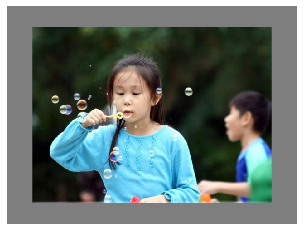

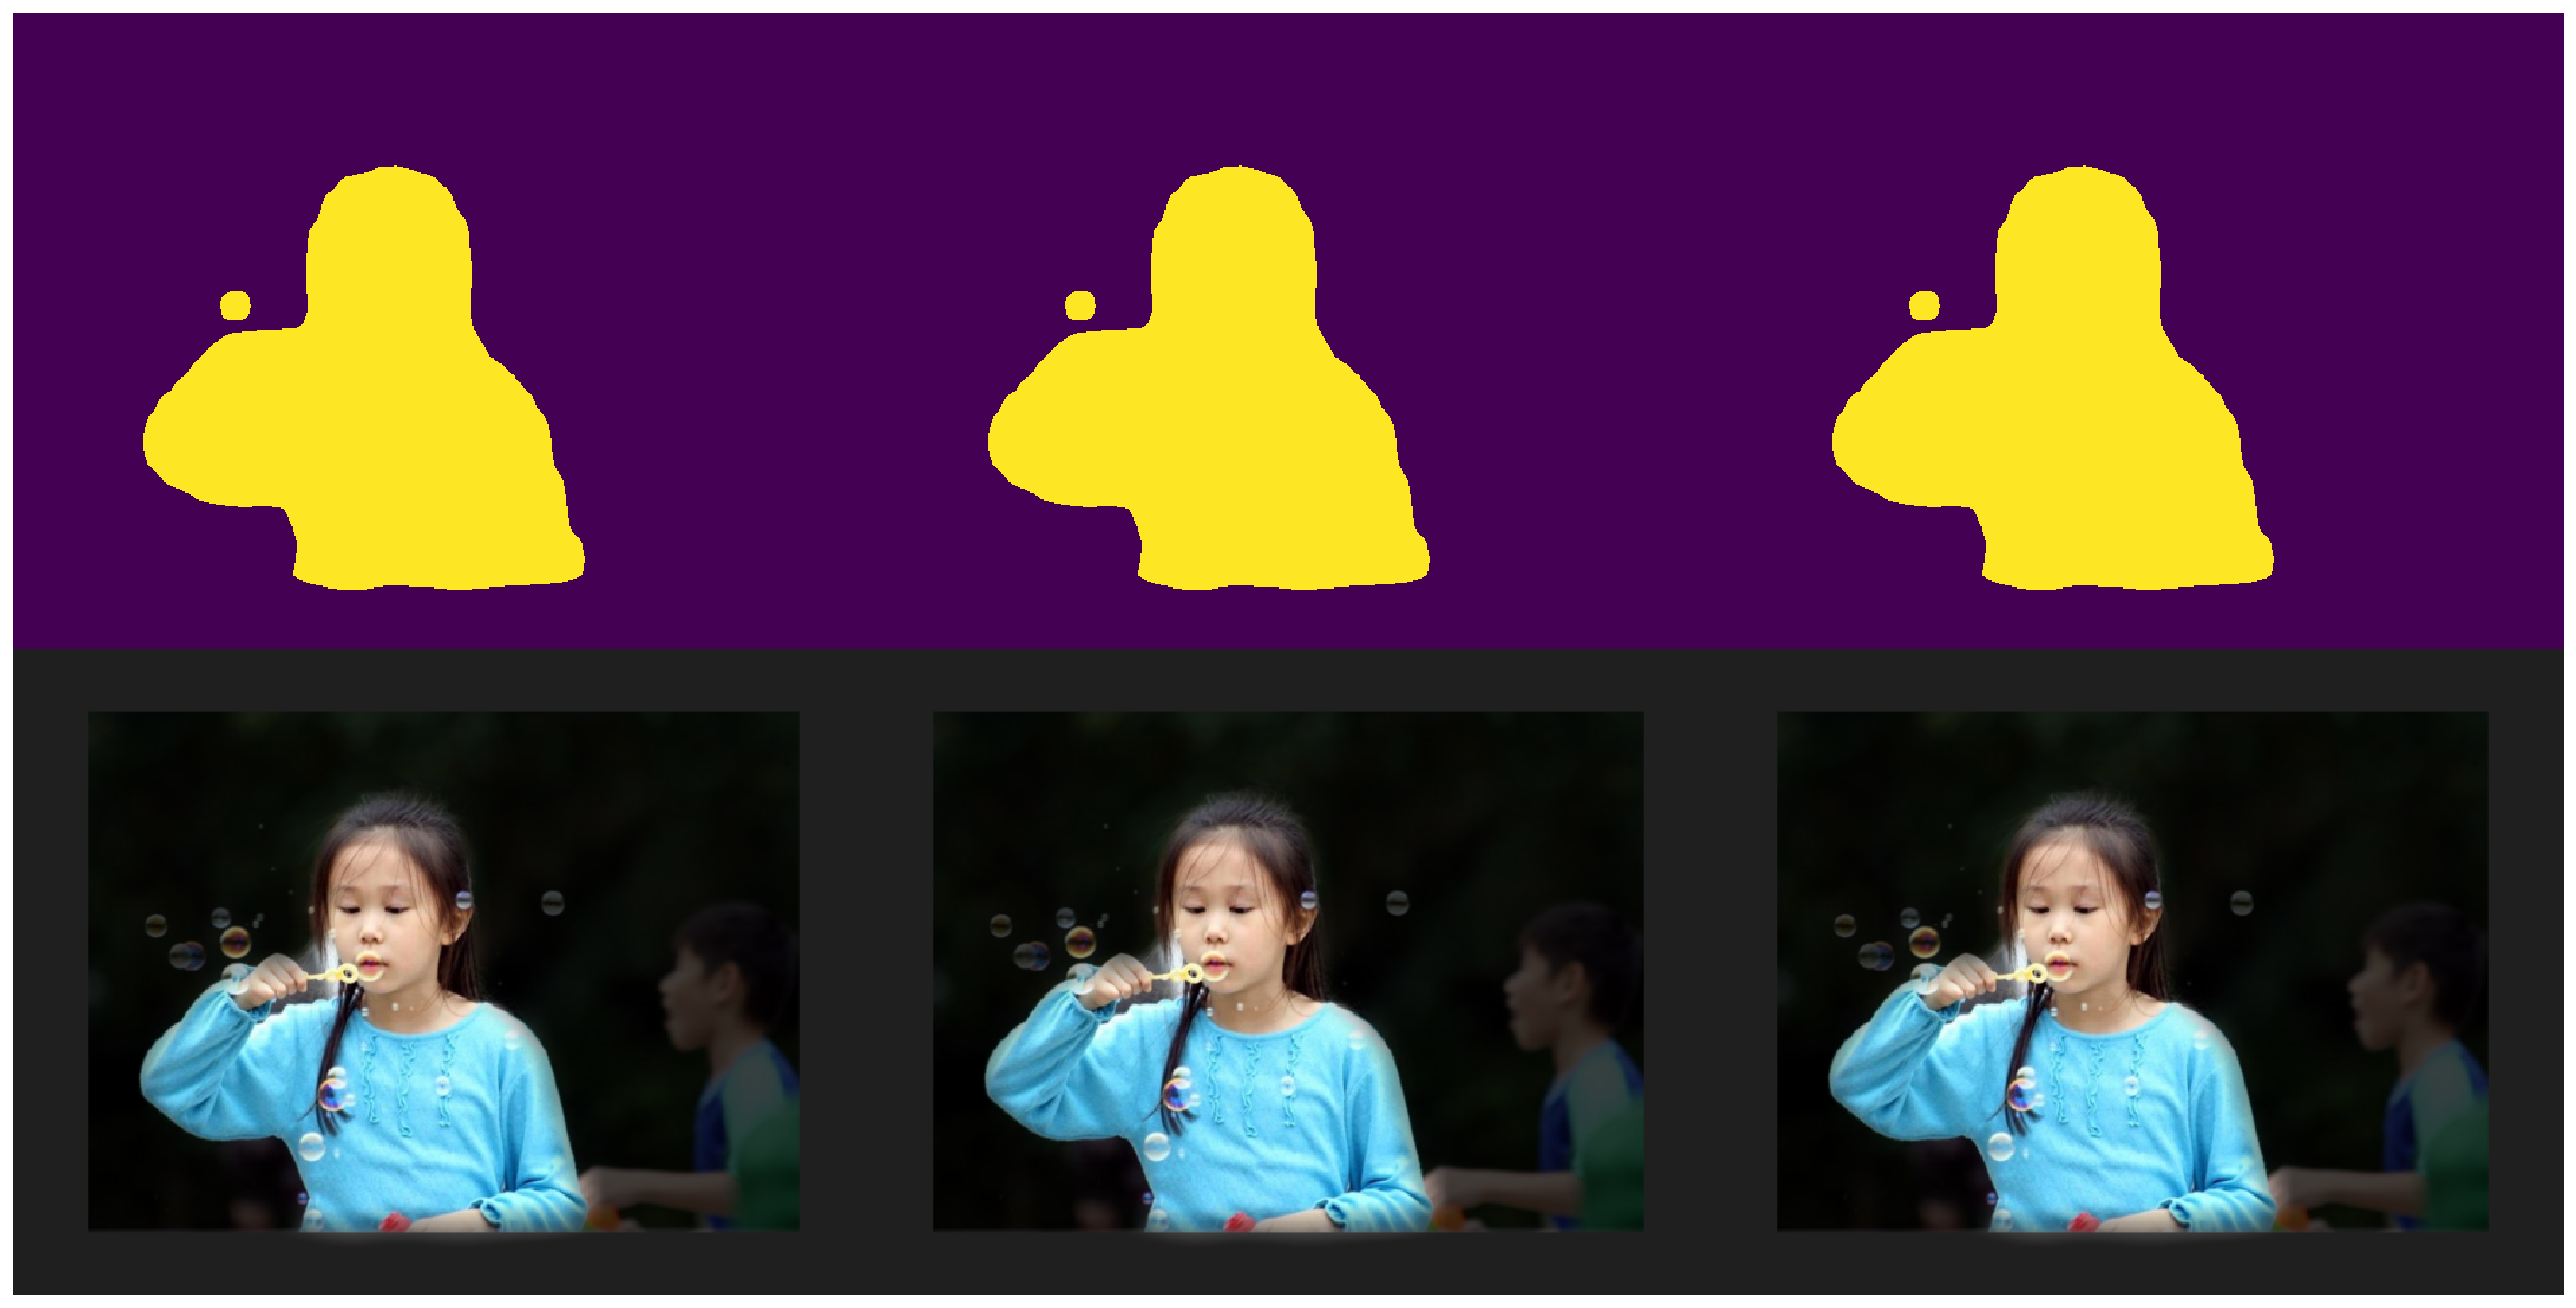

processing CAT2000Actions_003
Found too few objects in image CAT2000Actions_003; skipping
processing CAT2000Actions_005
Found too few objects in image CAT2000Actions_005; skipping
processing CAT2000Actions_007
Found too few objects in image CAT2000Actions_007; skipping
processing CAT2000Actions_009


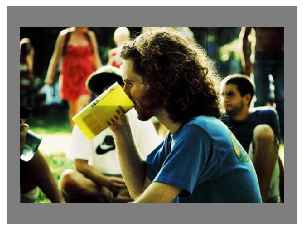

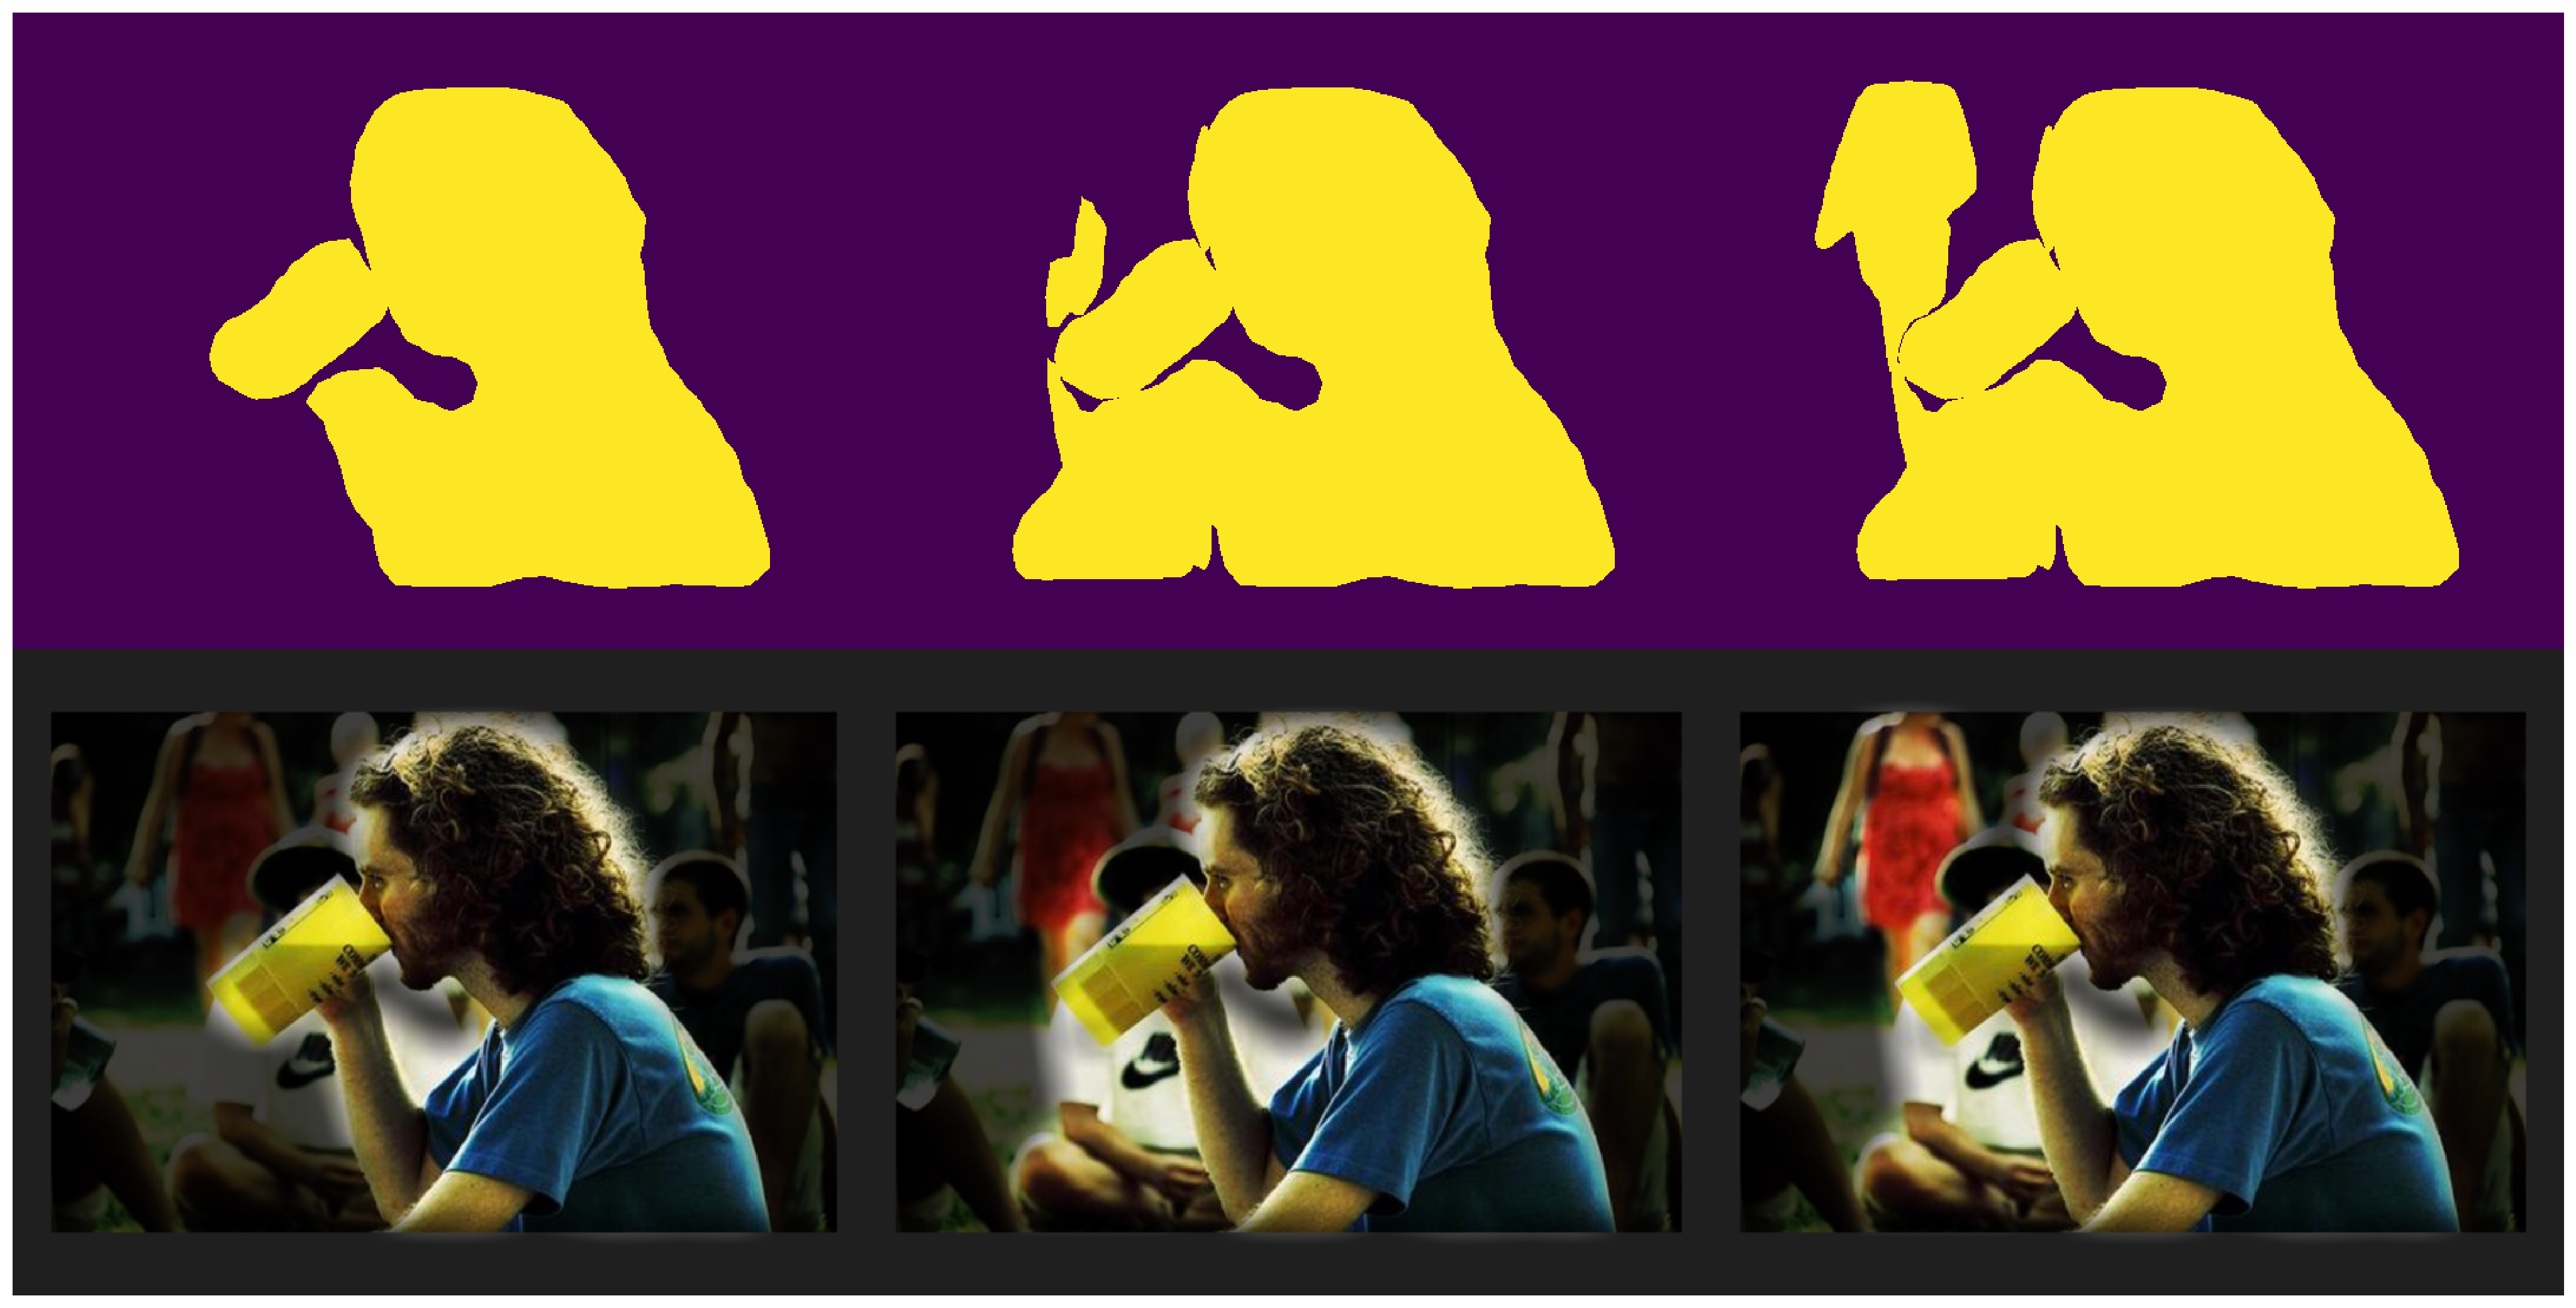

processing CAT2000Actions_011
Found too few objects in image CAT2000Actions_011; skipping
processing CAT2000Actions_013


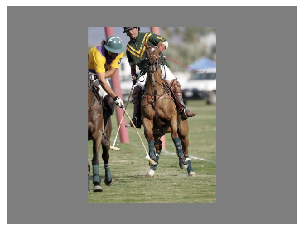

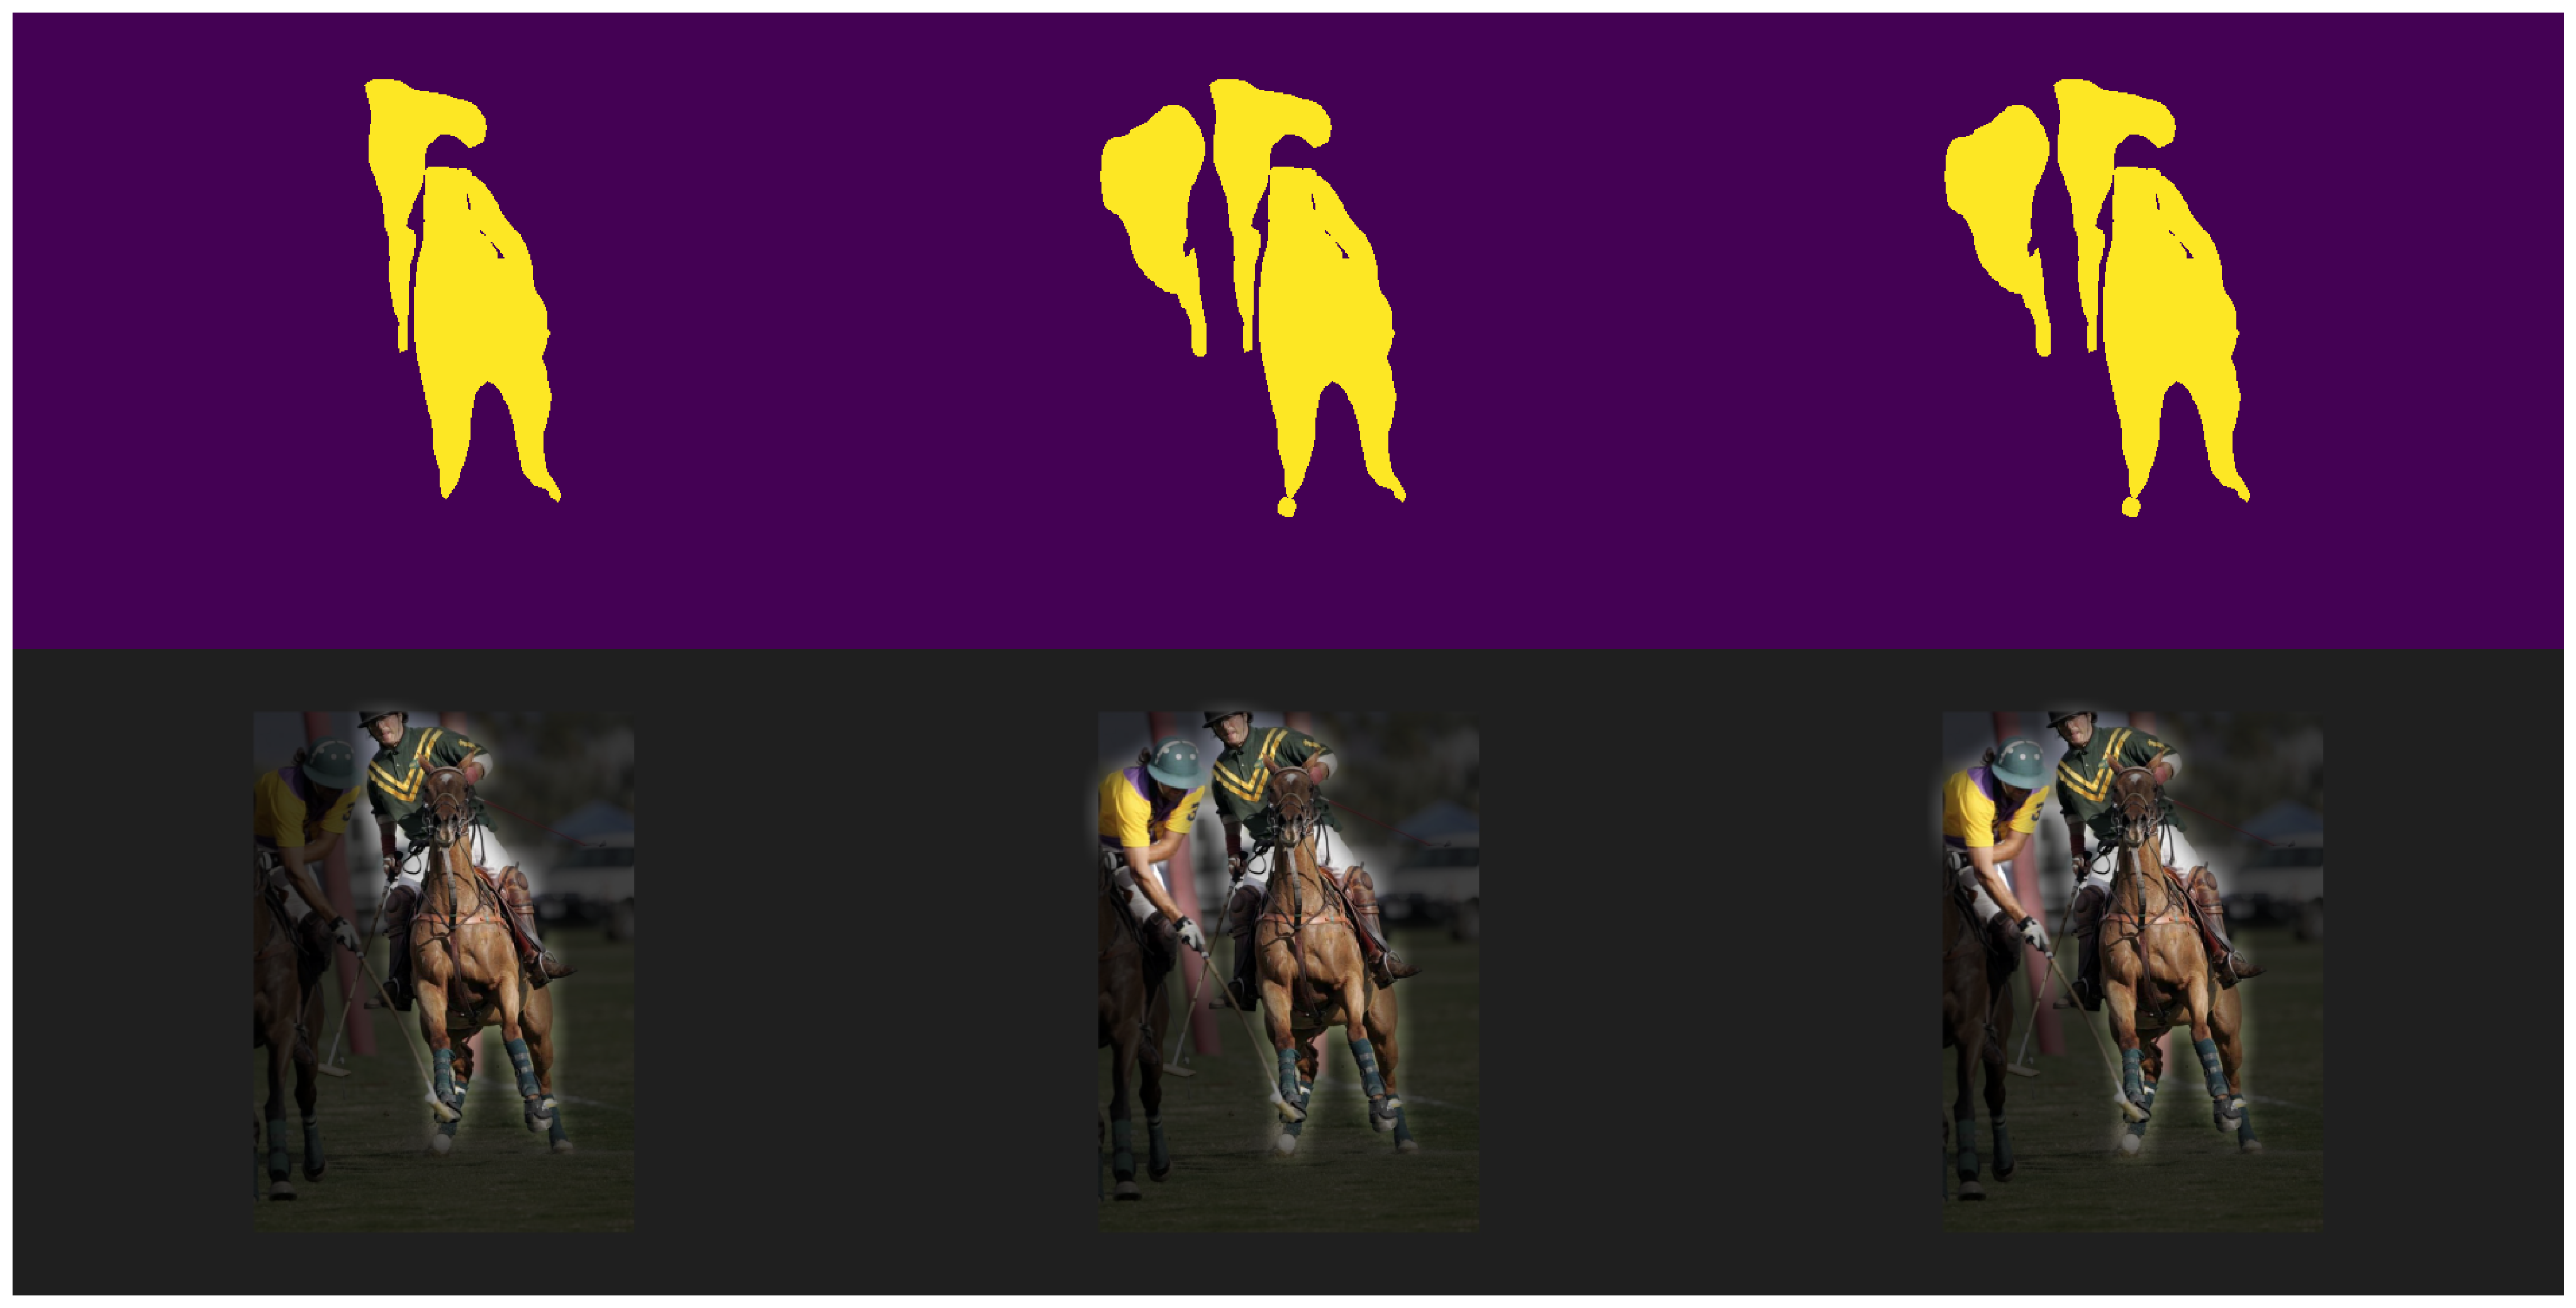

processing CAT2000Actions_015
Found too few objects in image CAT2000Actions_015; skipping
processing CAT2000Actions_017
Found too few objects in image CAT2000Actions_017; skipping
processing CAT2000Actions_019


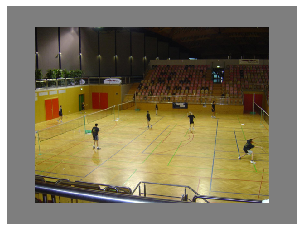

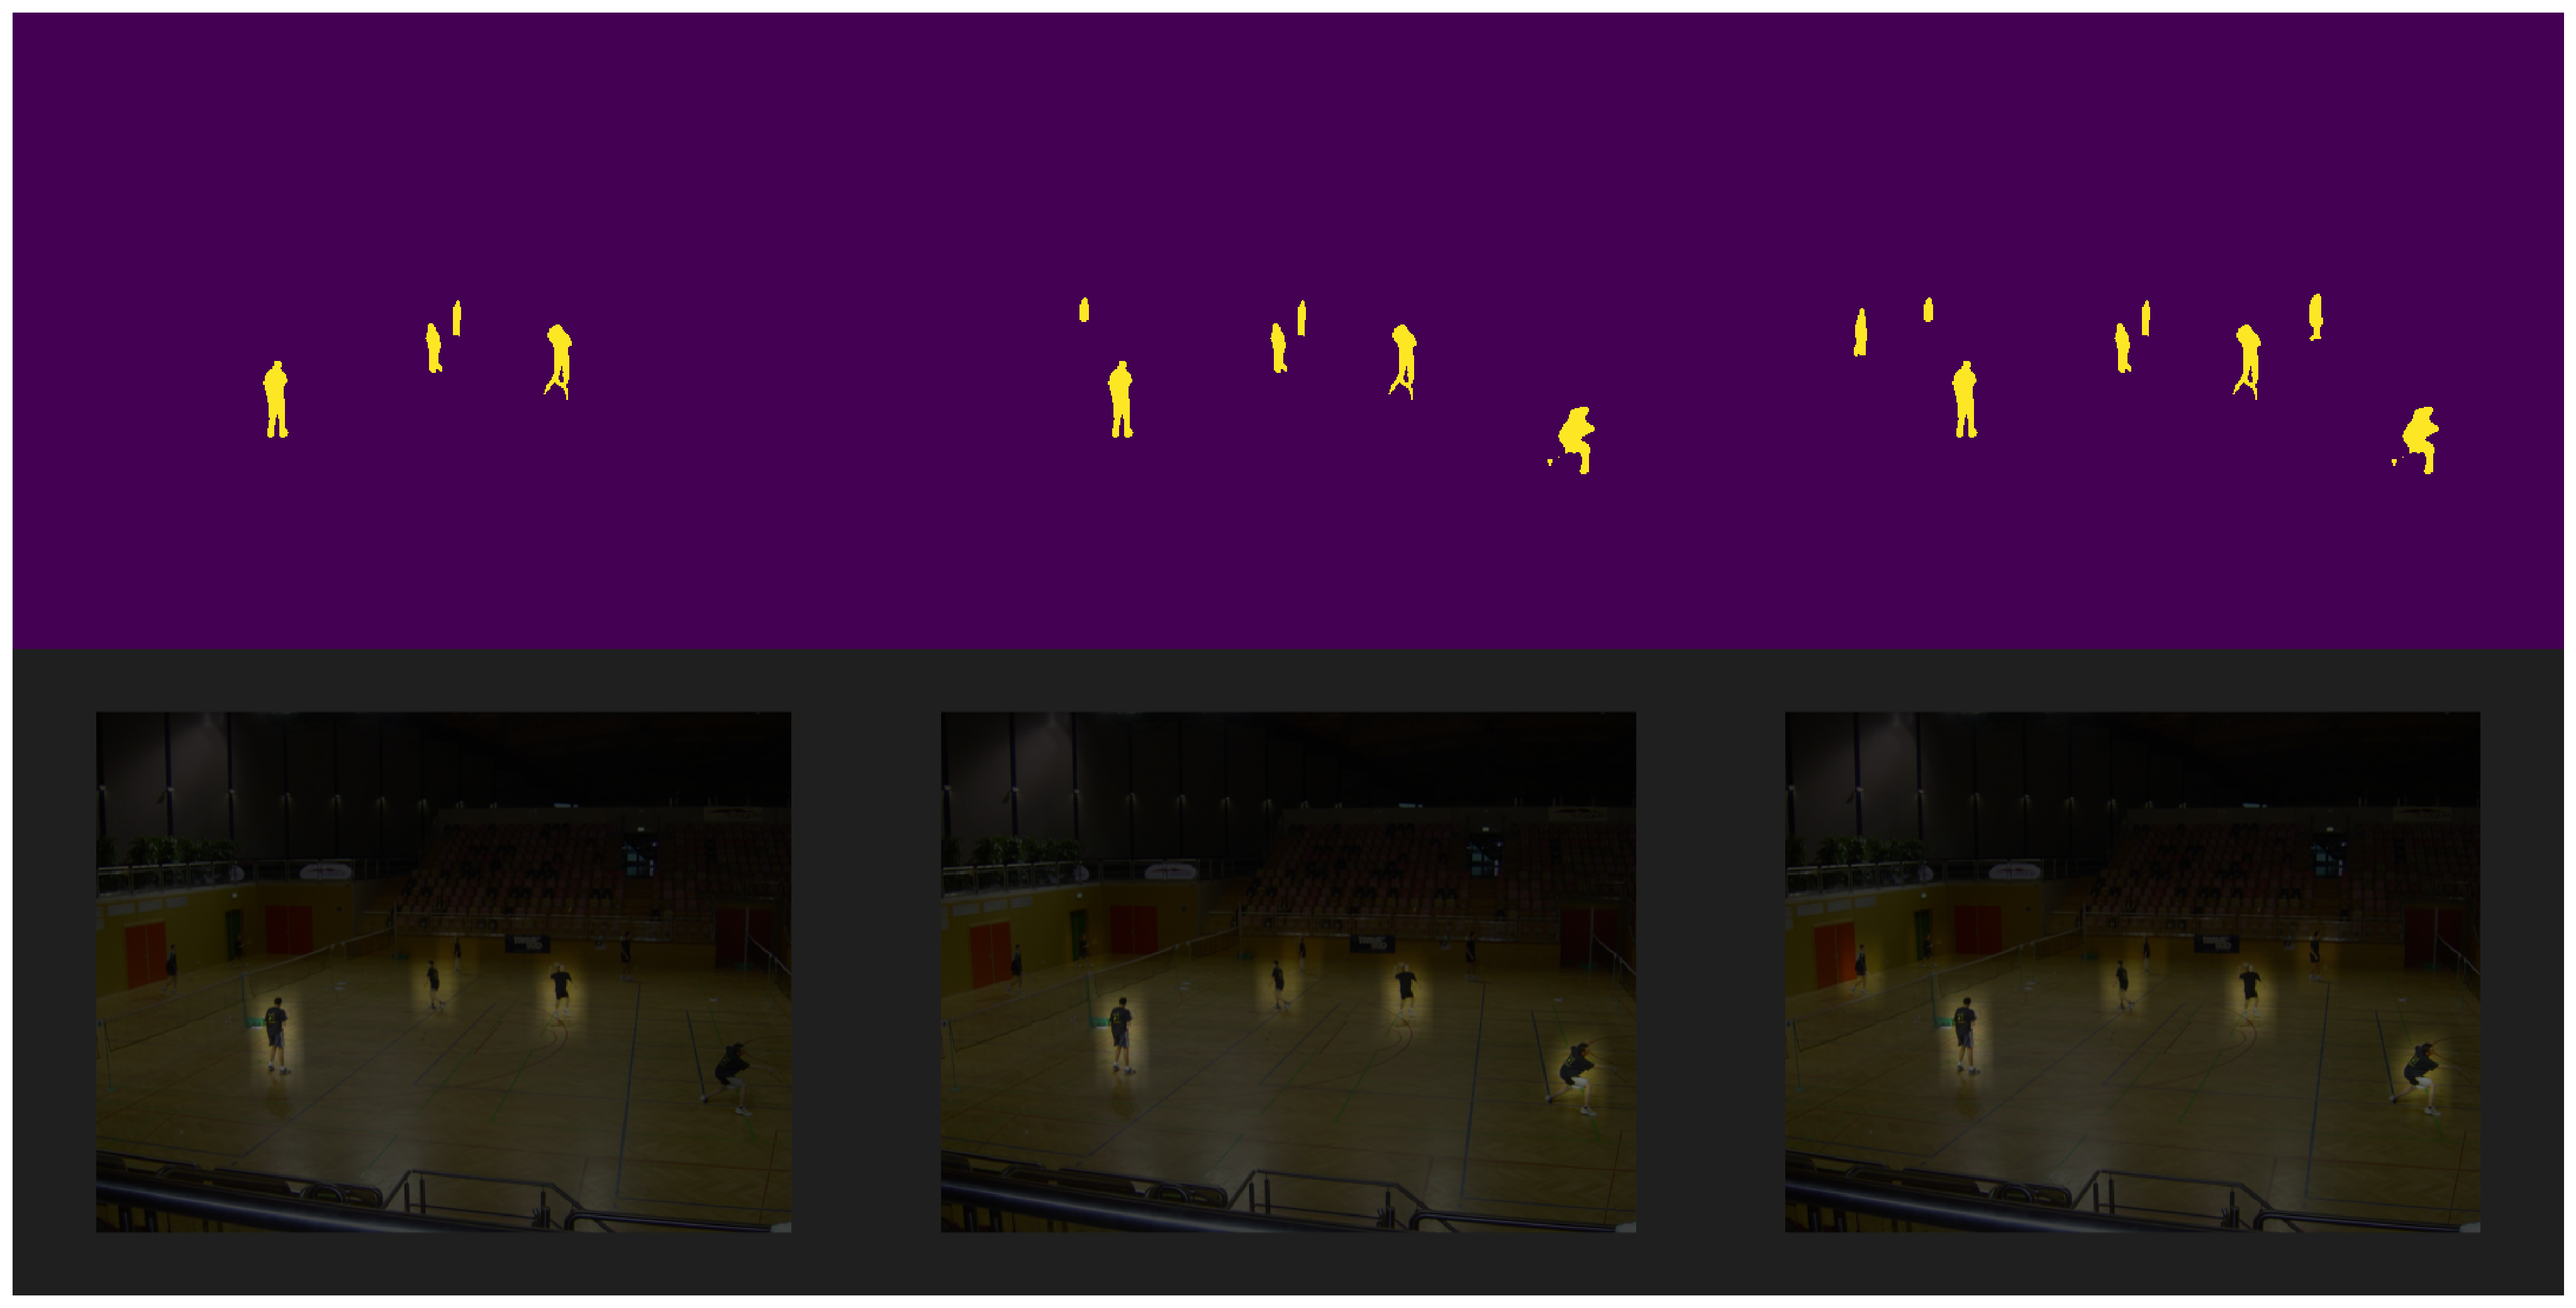

processing CAT2000Actions_021


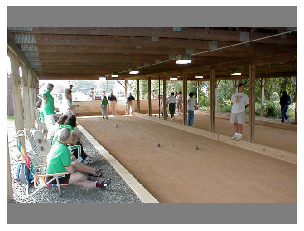

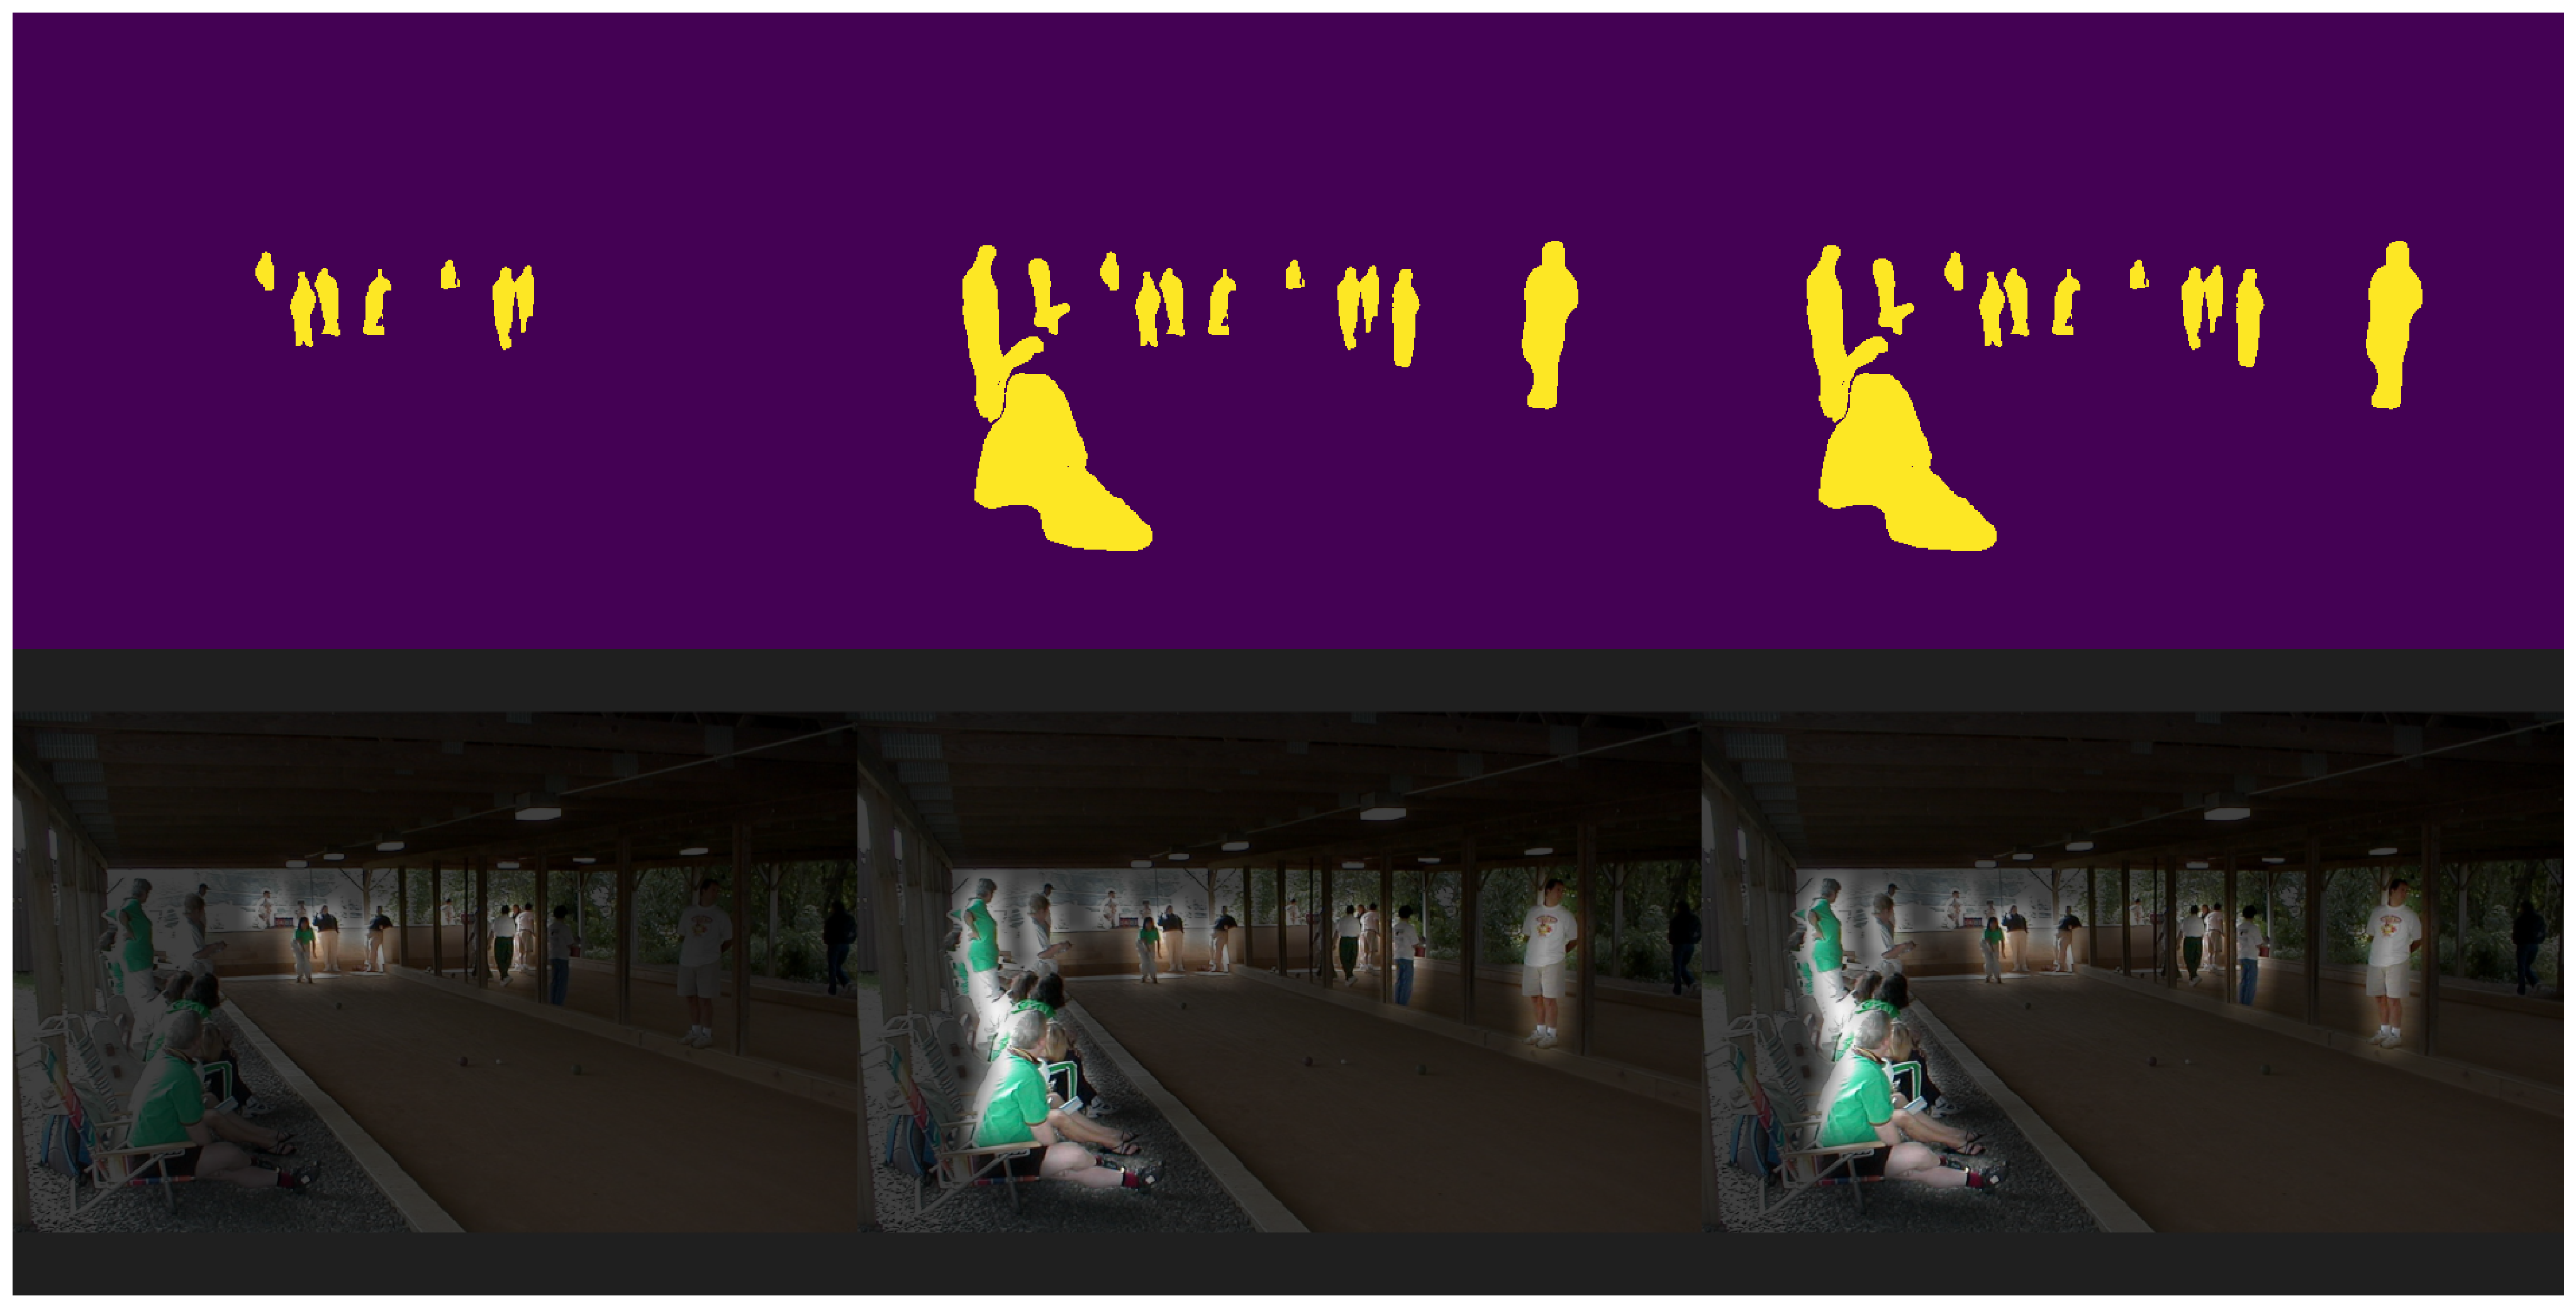

processing CAT2000Actions_023


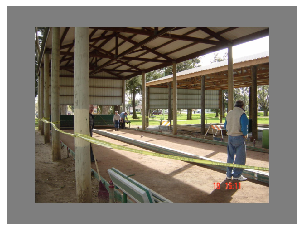

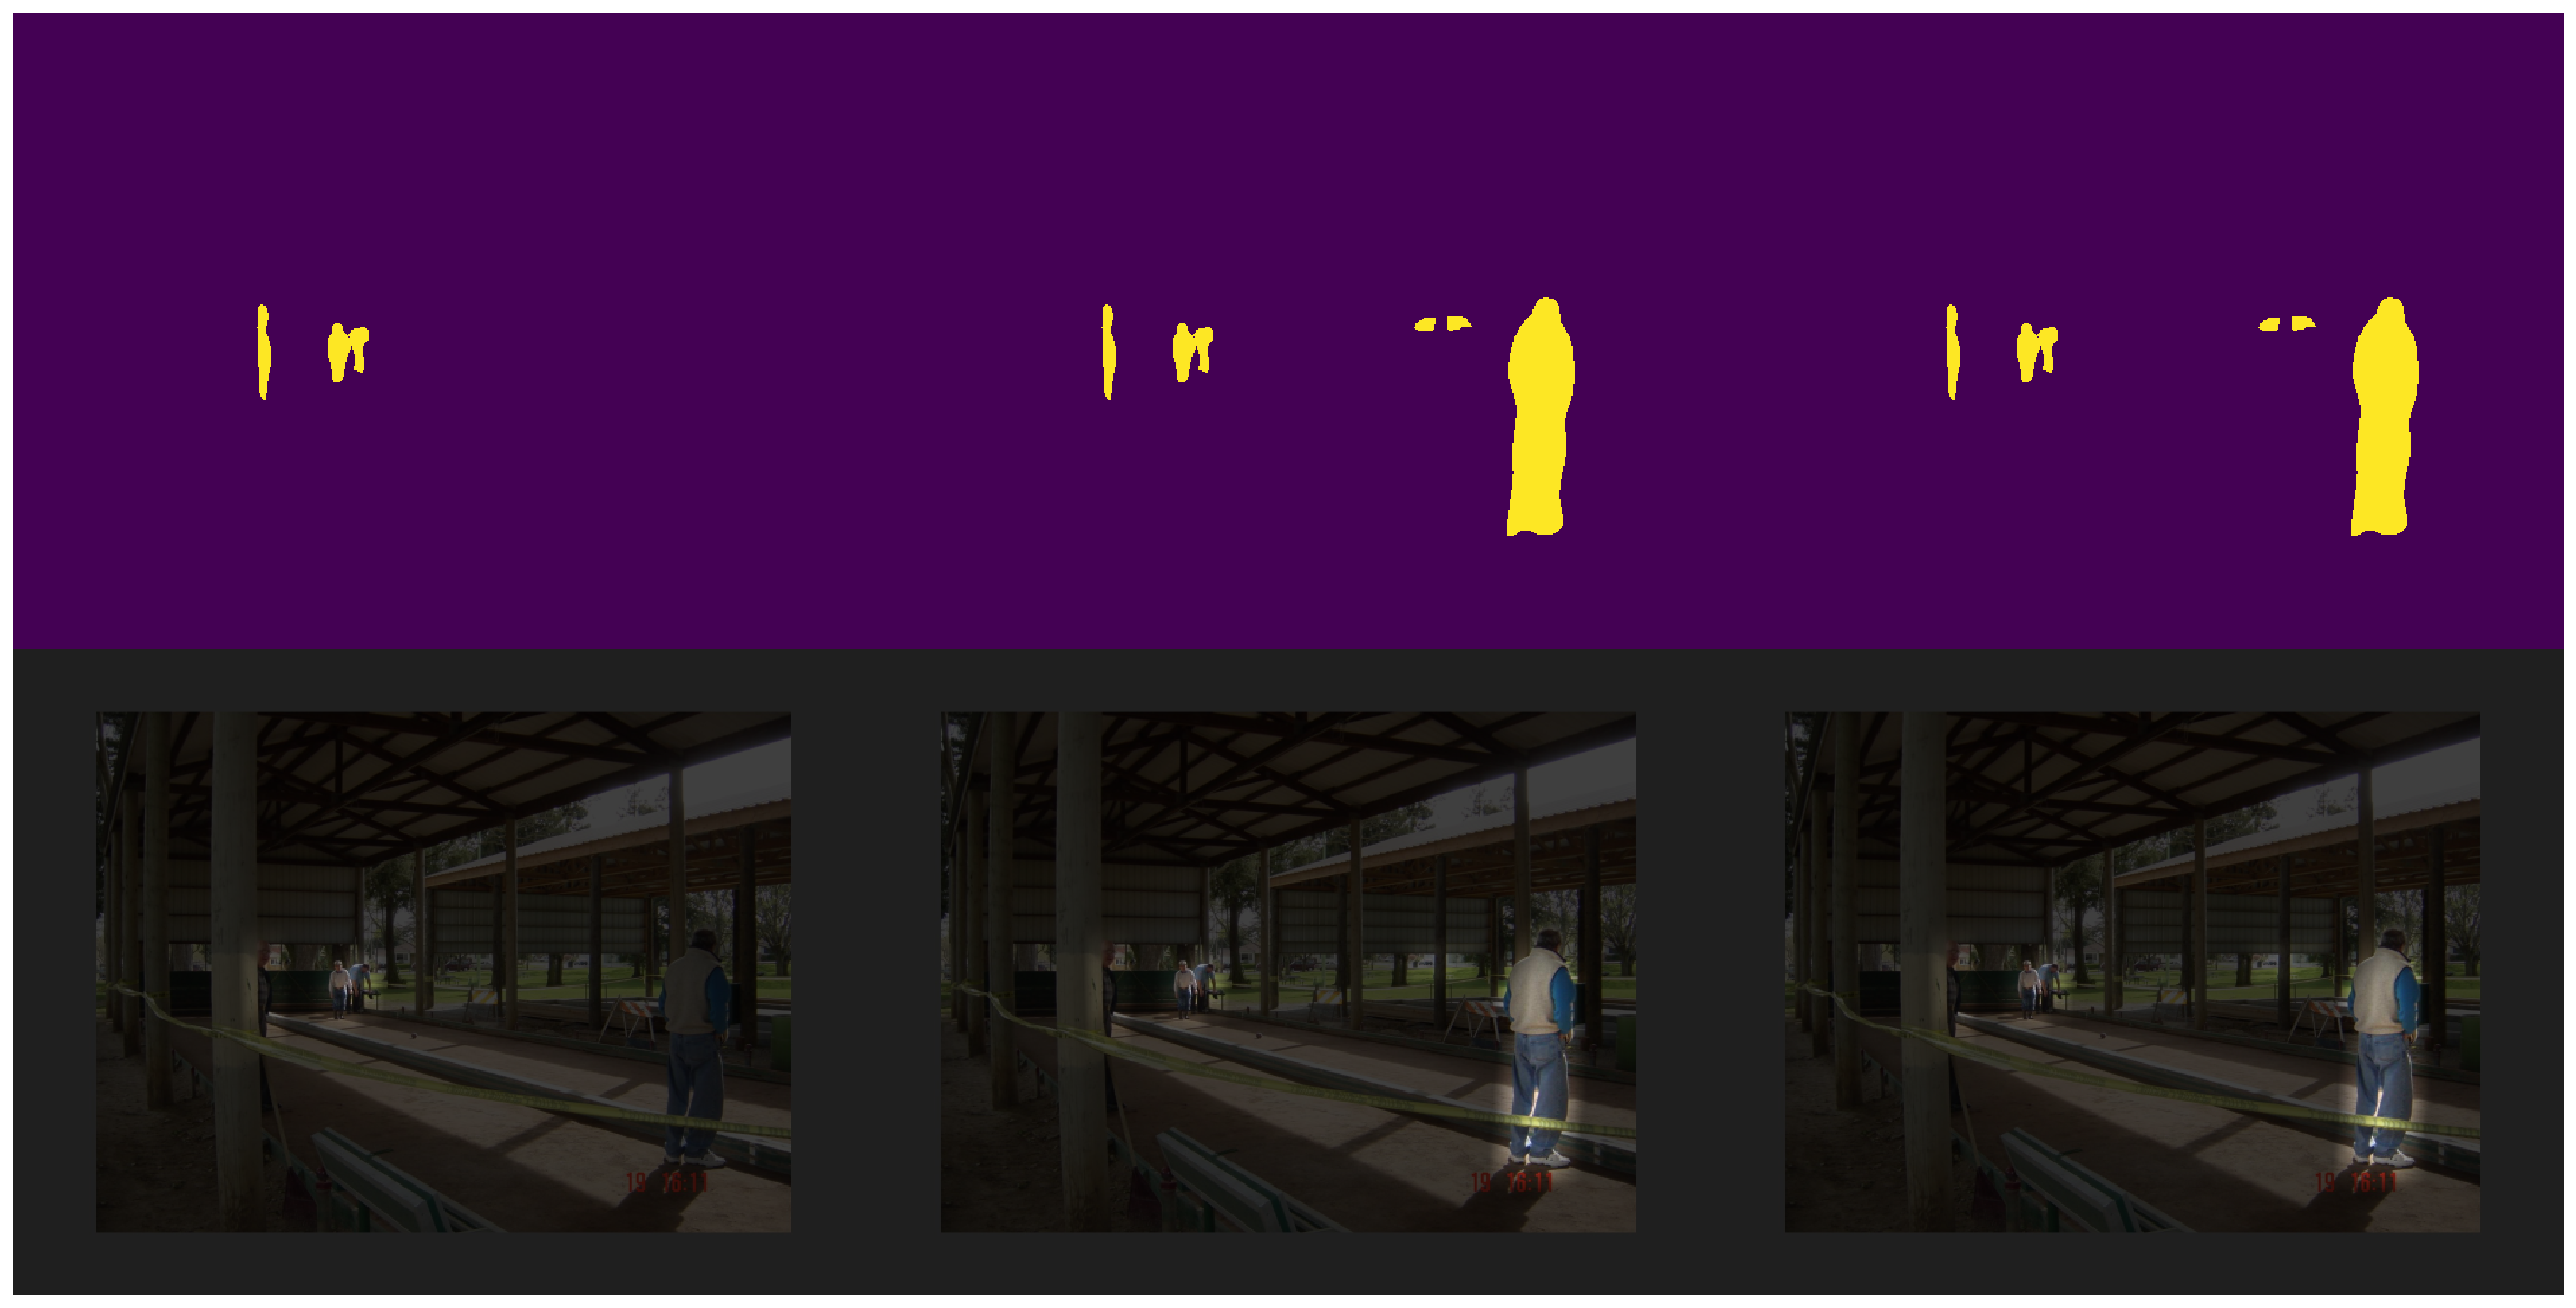

processing CAT2000Actions_025


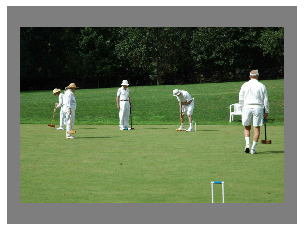

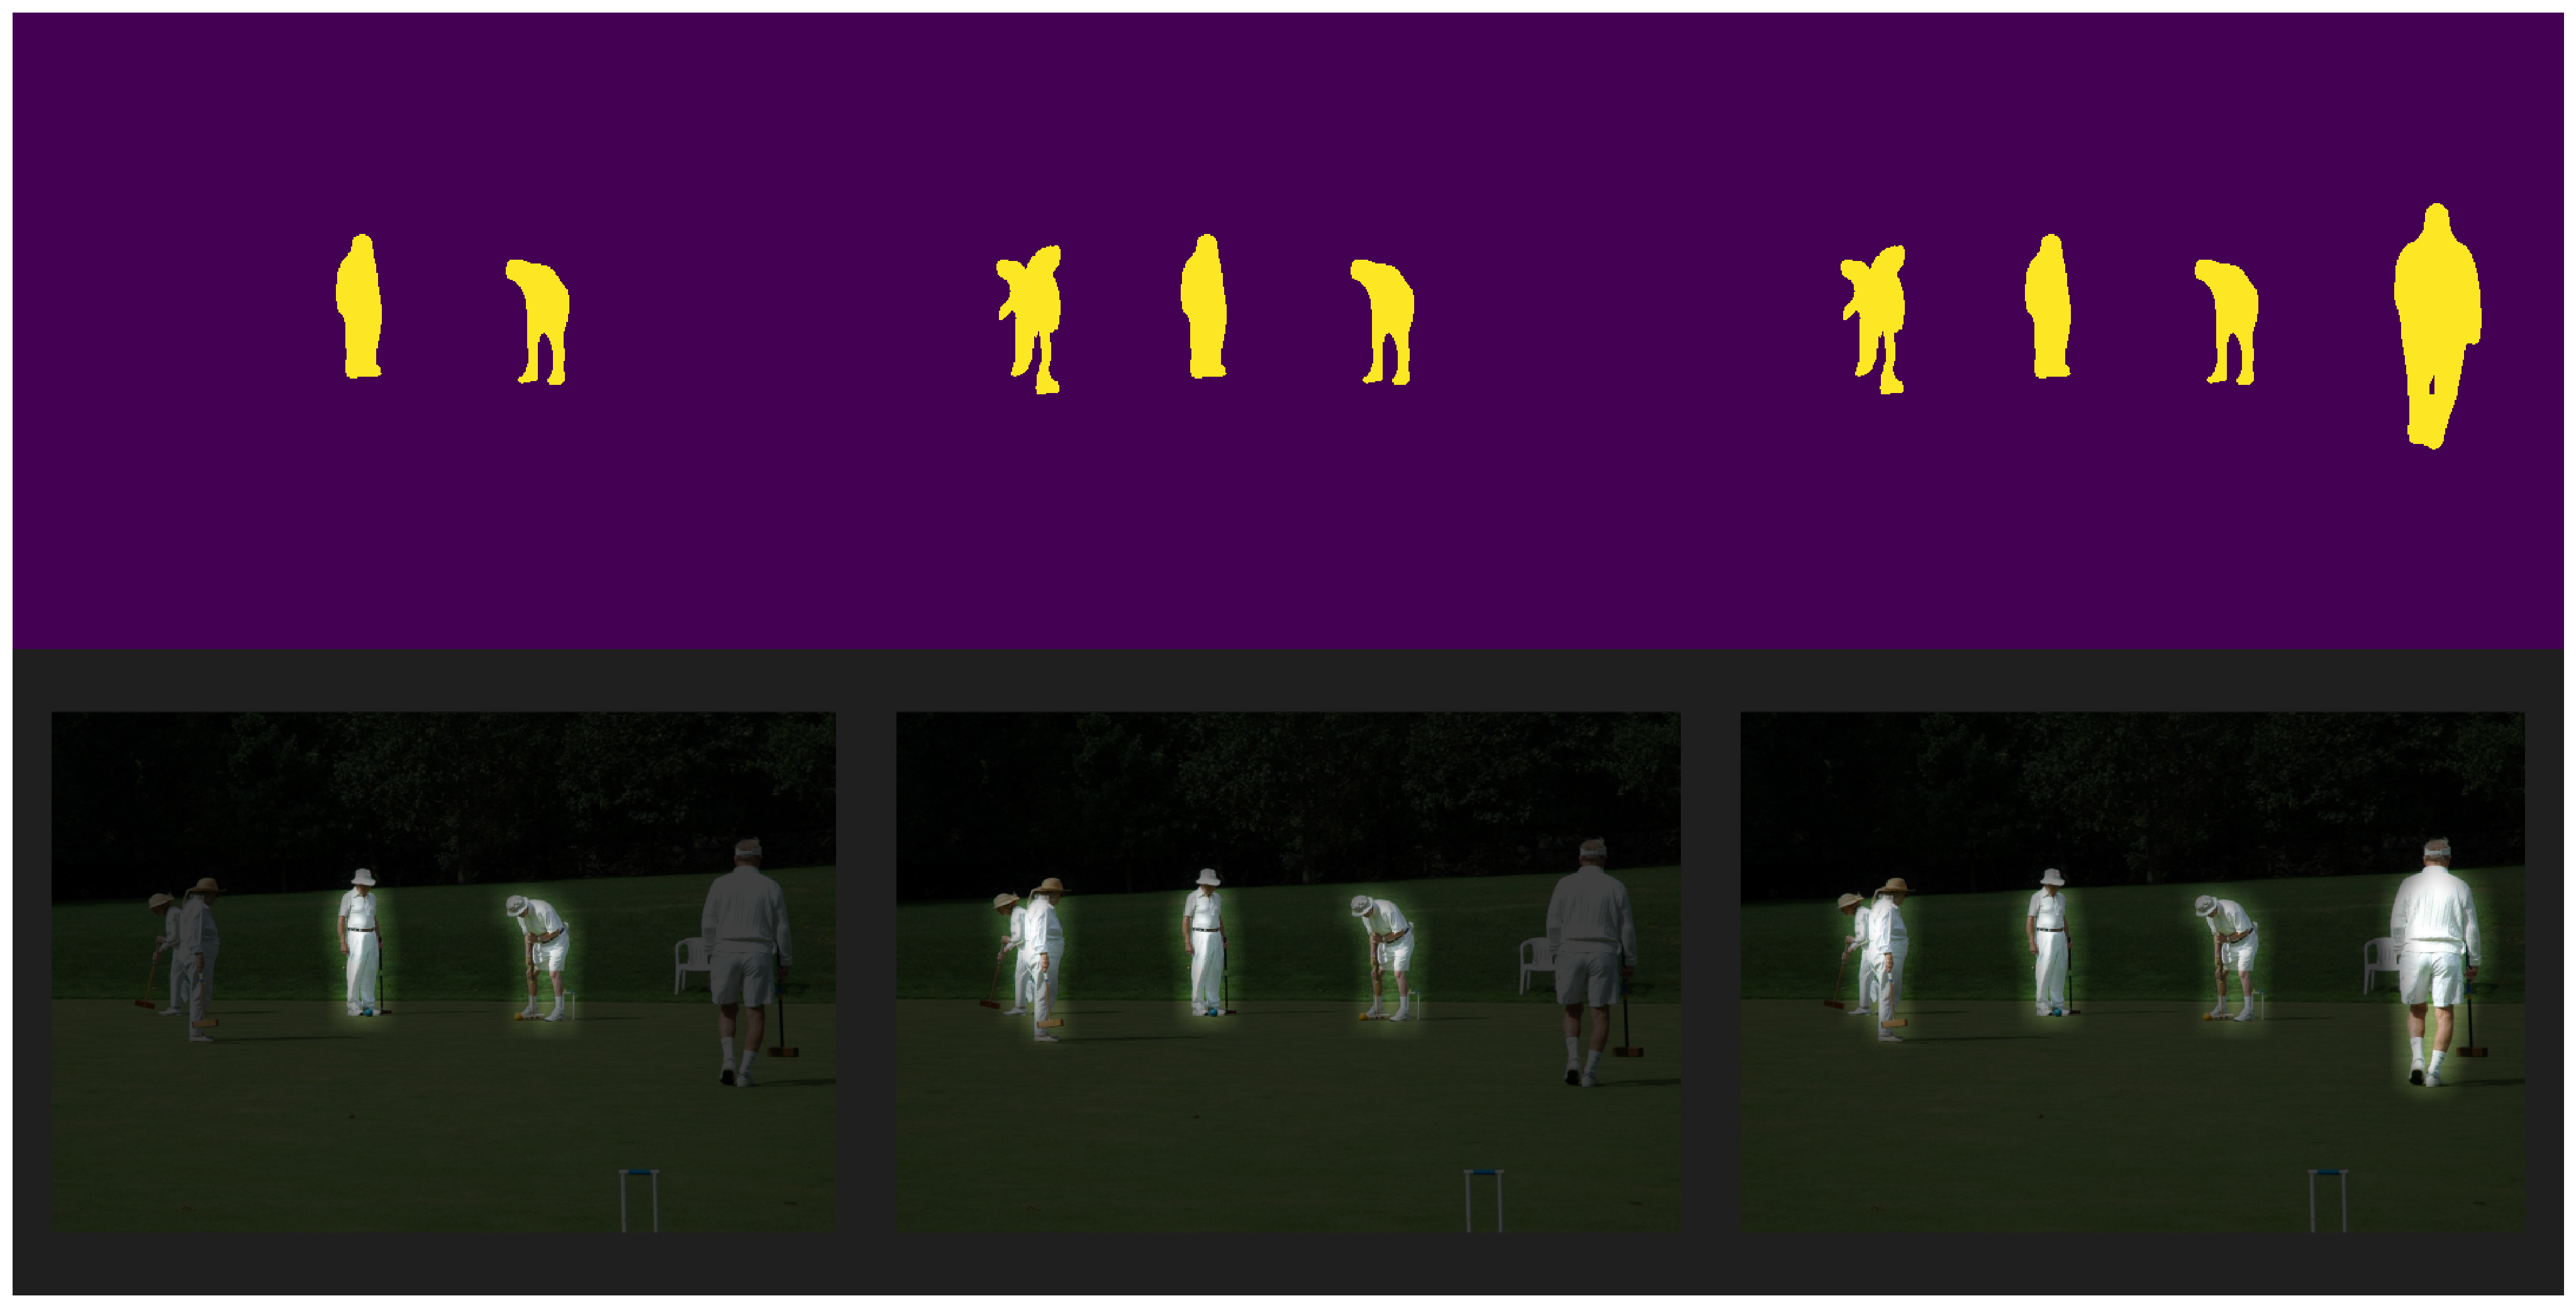

processing CAT2000Actions_027


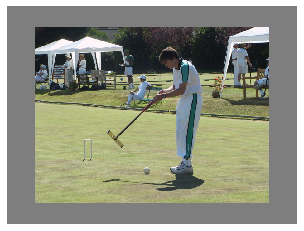

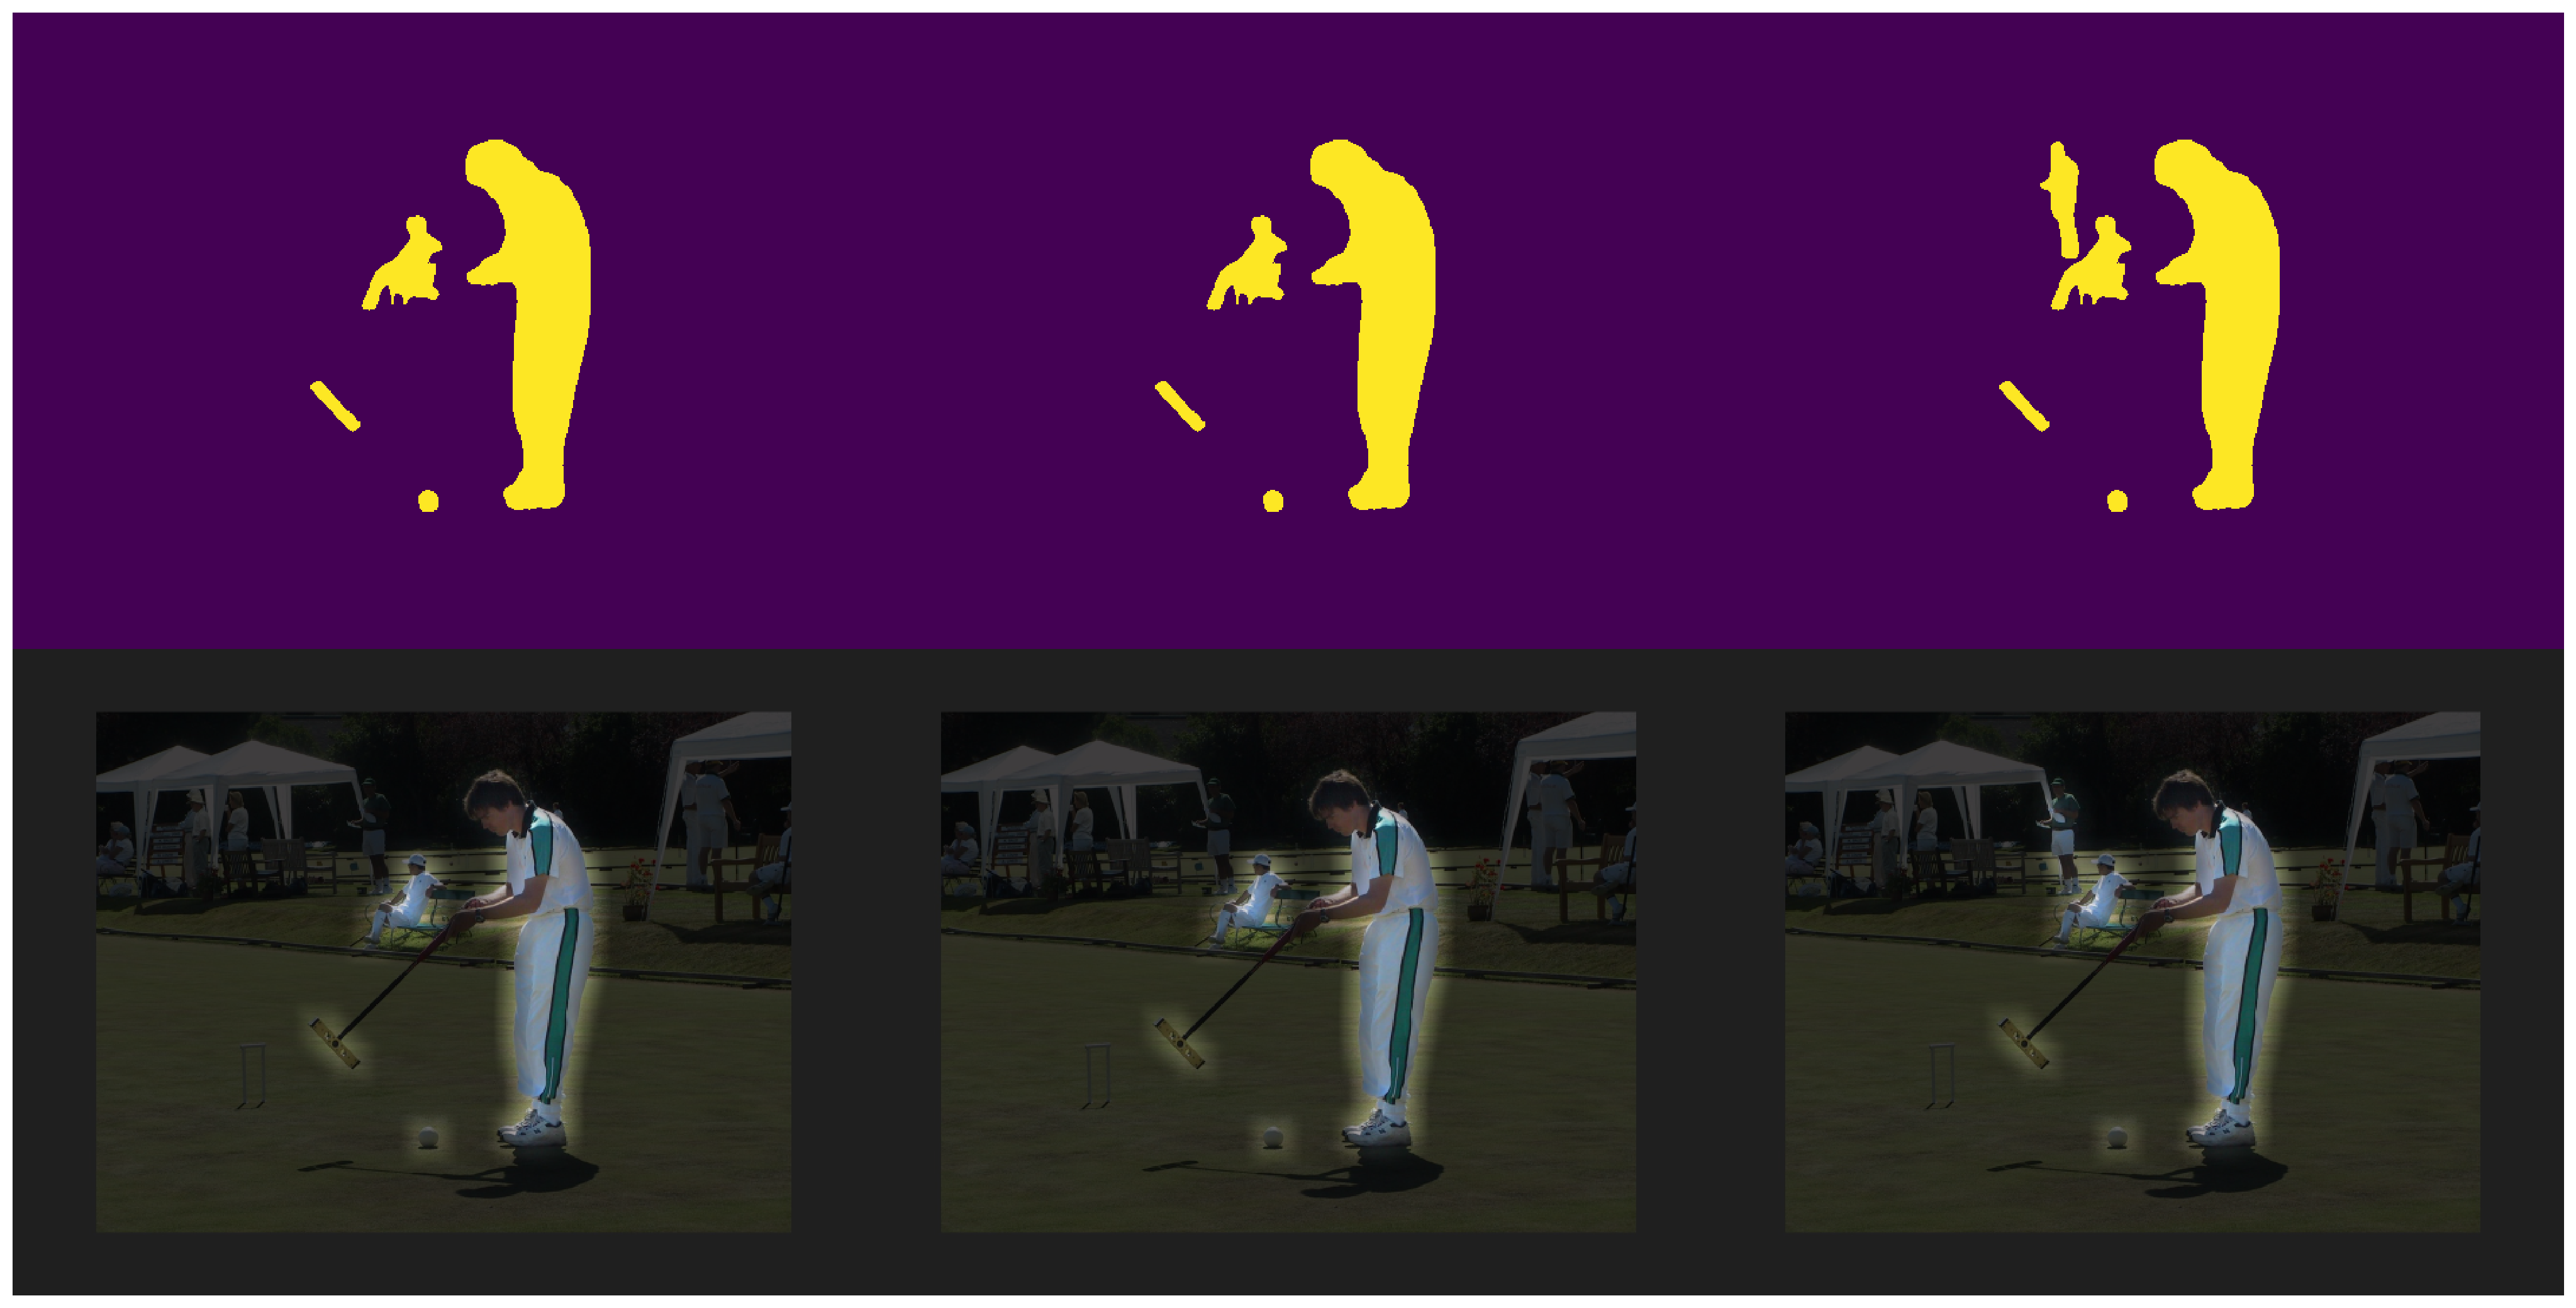

processing CAT2000Actions_029


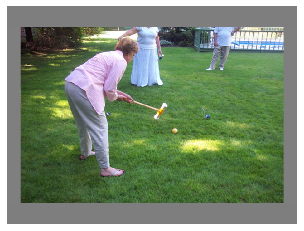

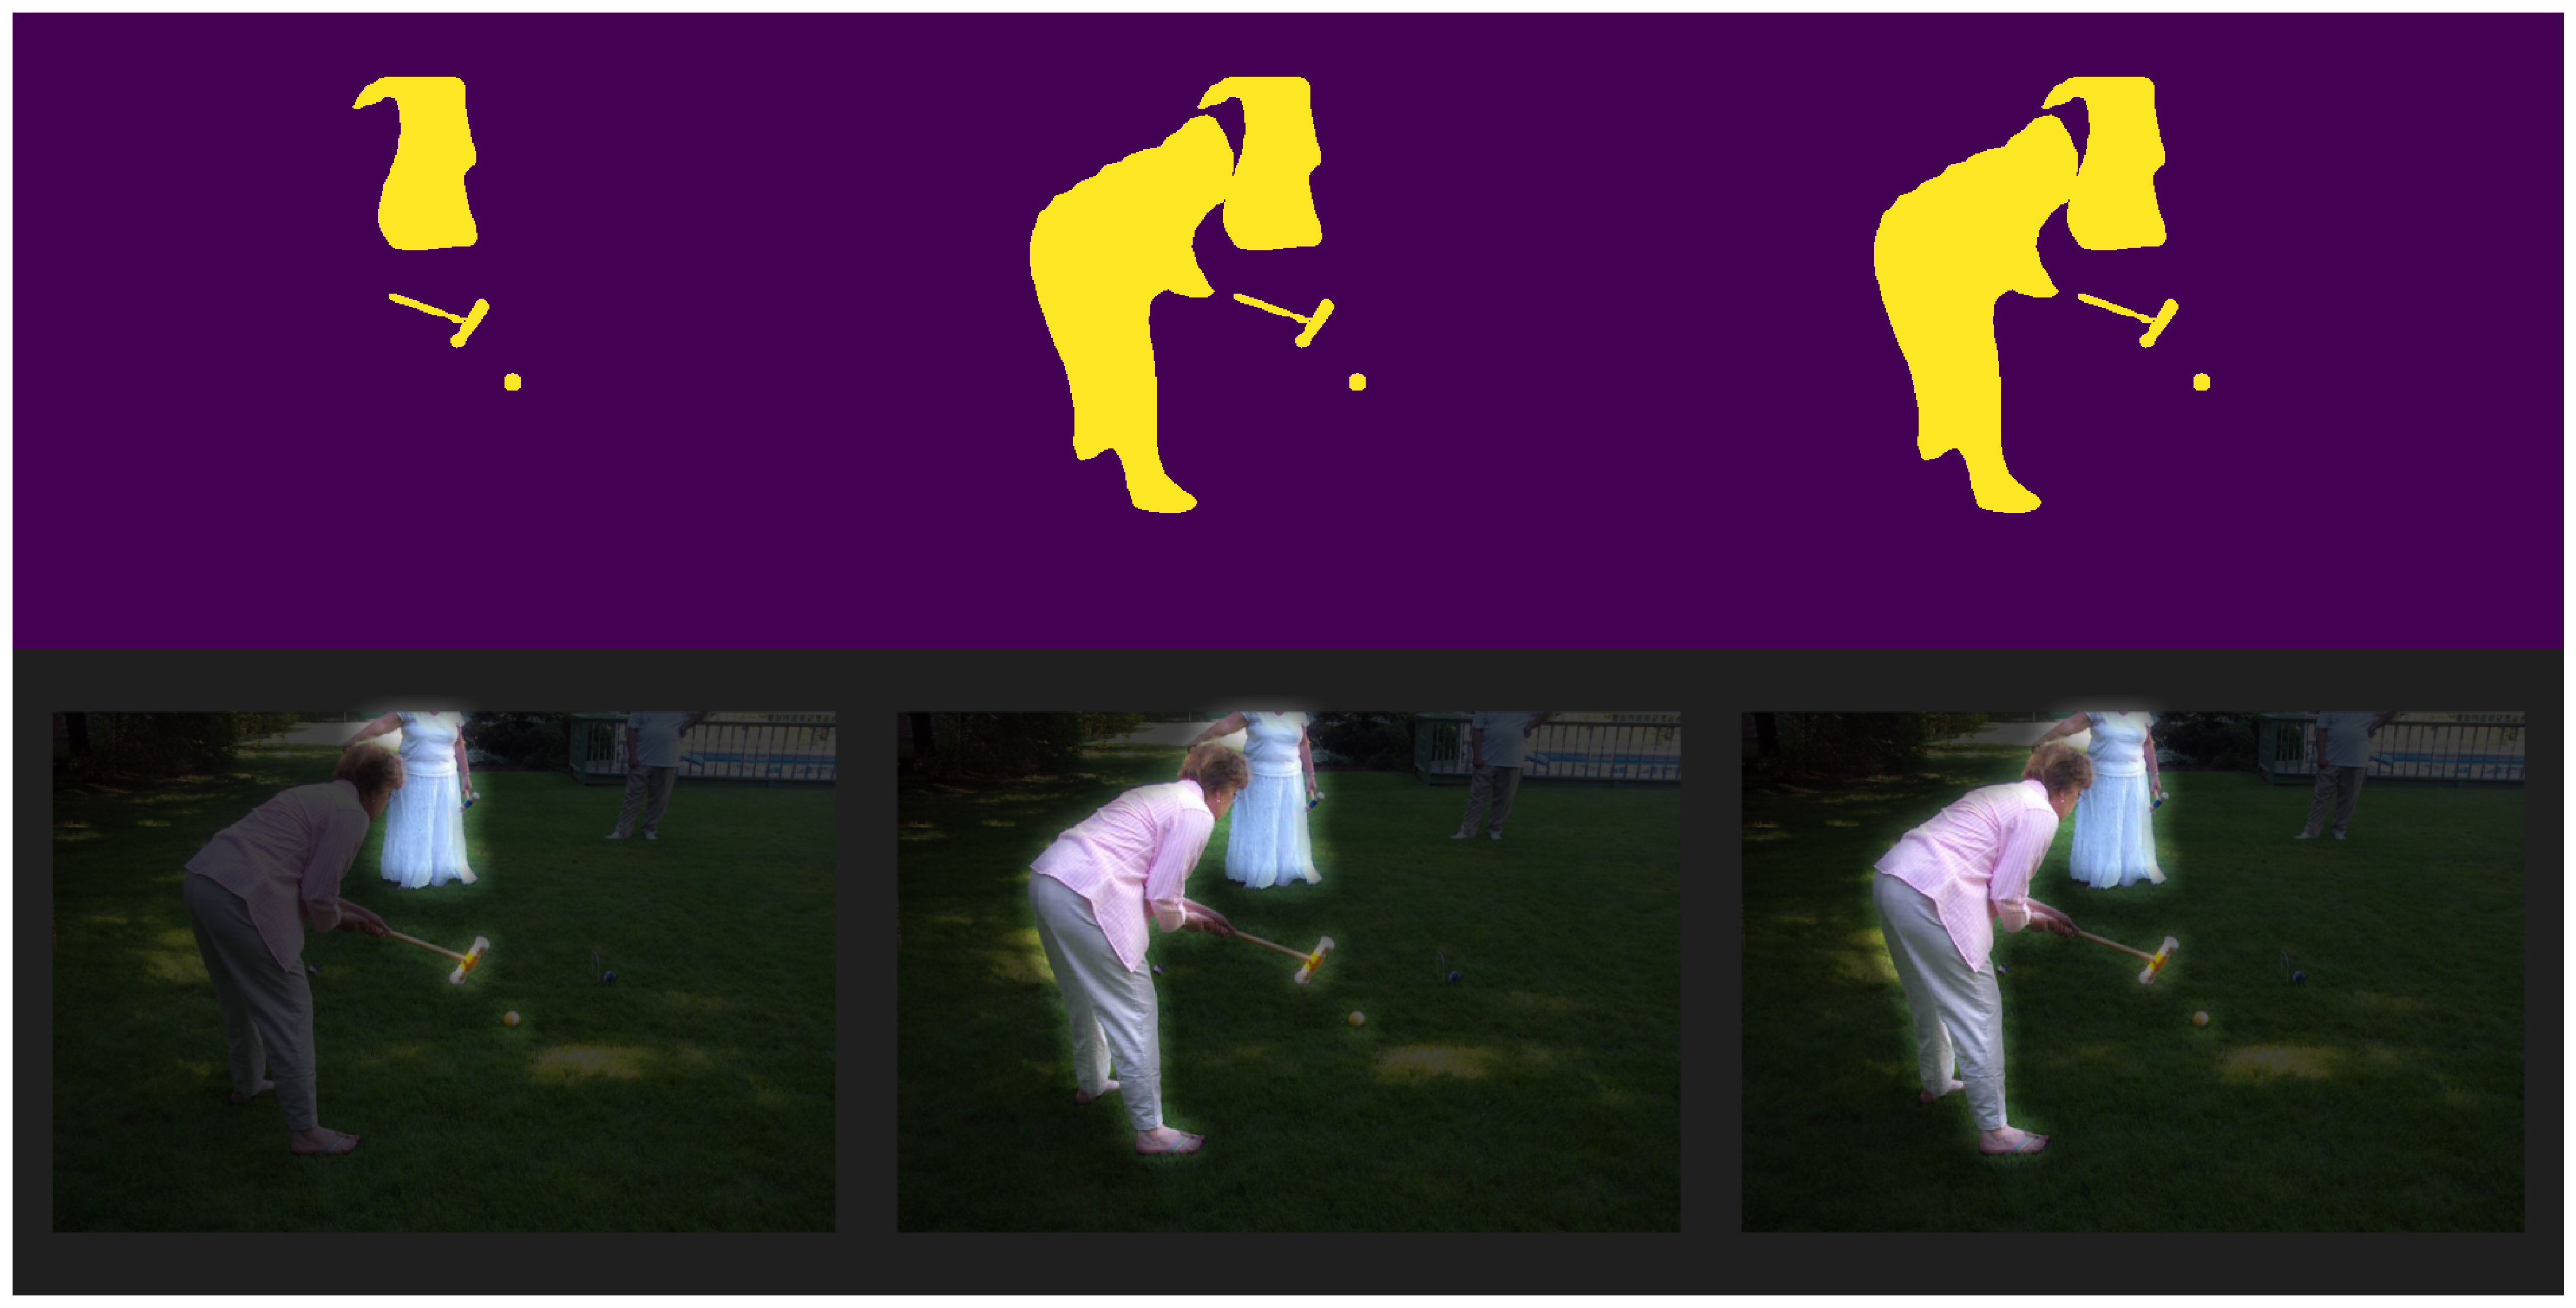

In [62]:
sigma=20
total_thr = []
print("Processing {} images".format(len(selected_images)))
for img_name in tqdm(selected_images):  
    print('processing {}'.format(img_name))
    img_file = img_name+'.'+ori_filetype
    image = cv2.imread(os.path.join(codecharts_images_path,img_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if RESIZE:
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    imgblurred = cv2.GaussianBlur(image, (25,25), 0)
    imgblurred[:,:,:] = imgblurred[:,:,:]/4
    
    # Mask RCNN
    results = model.detect([image], verbose=0)        
    r = results[0]
        
    combined_mask = np.sum(r['masks'],axis=2)
    num_masks = r['masks'].shape[2]

    if (num_masks <= 5): 
        print("Found too few objects in image {}; skipping".format(img_name))
        continue
    instance_counts = np.zeros(num_masks)
           
    segmented_masks = r['masks']
    
    sal_imname = img_name + '.{}'.format(sal_filetype)
    sal_impaths = [os.path.join(saliency_path, sal_imname) for saliency_path in saliency_paths]
    prev_heatmaps = []
    if should_plot:
        plt.imshow(image)
        ax = plt.gca()
        ax.axis('off')
        plt.show()
        fig,axes = plt.subplots(2,3,figsize=(20,10),dpi=200)
        axes = axes.flatten()
        for ax in axes:
            ax.axis('off')
    current_heatmap = np.zeros(image.shape[:2])
    threshold = 0.0
    for i, sal_impath in enumerate(sal_impaths):
        time_img_file = '{}_{}'.format(time_points[i], img_file)
        
        heatmap = cv2.imread(sal_impath, 0)
        if (RESIZE):
            heatmap = cv2.resize(heatmap, dim, interpolation = cv2.INTER_AREA)
        
        prev_heatmaps.append(heatmap.copy())
        current_heatmap+=heatmap
        if i==0:
            # pick 90 percentile
            threshold = np.percentile(current_heatmap.flatten(),90)

                
        for idx in range(num_masks):
            instance_counts[idx] = np.mean(current_heatmap[segmented_masks[:,:,idx]])
        indices = np.arange(len(instance_counts))[instance_counts > threshold]
        diff_list = list(set(np.arange(num_masks))-set(indices))   
        
        imp_mask = np.any(segmented_masks[:,:,indices], axis=2)
        
        new_img = image.copy()
        blur_mask = np.where(imp_mask.astype(int), 1, 1/4)
        blur_img = cv2.blur(blur_mask,(30,30))
        for k in range(3):
            new_img[:,:,k] = new_img[:,:,k]*blur_img
        
        
        if should_plot:
            axes[i].imshow(imp_mask)
            axes[i+3].imshow(new_img)
        if should_save:
            savepath = os.path.join(results_savepath, "{}_{}.jpg".format(time_points[i], img_name))
            status = cv2.imwrite(savepath, cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
            if not status: 
                print("ERROR saving image")
    
    if should_plot:
        plt.tight_layout(pad=-1)
        plt.show()
    total_thr.append(threshold)